# Training

In [36]:
# import stantment
import random
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from traffic_env import TrafficEnv
from problem_modulation import MAX_CARS

# Config
alpha = 0.6
gamma = 0.9
epsilon = 0.2
epsilon_decay = 0.995
epsilon_min = 0.05
episodes = 5000
max_steps = 50

os.makedirs("../data/models", exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_dir = "../data/training_logs"
os.makedirs(log_dir, exist_ok=True)

In [37]:
def ensure_dir(path: str):
    """
    Ensure that a directory exists at the specified path.

    Args:
        path (str): The path of the directory to check or create.

    Notes:
        - If the directory does not exist, it will be created automatically.
        - If the directory already exists, no action is taken.
    """
    if not os.path.exists(path):
        os.makedirs(path)

In [38]:
def choose_action(Q: np.ndarray, state: tuple[int, int], epsilon: float) -> int:
    """
    Select an action using an epsilon-greedy policy.

    With probability `epsilon`, the agent explores by choosing a random action.
    Otherwise, it exploits current knowledge by selecting the action with the
    highest Q-value for the given state.

    Args:
        Q (np.ndarray): Q-table of shape (MAX_CARS+1, MAX_CARS+1, 2),
            where the last dimension indexes actions.
        state (tuple[int, int]): Current state as (n1, n2), i.e., number of cars
            on road 1 and road 2, respectively.
        epsilon (float): Exploration rate in [0, 1]. Higher values increase the
            probability of choosing a random action.

    Returns:
        int: The selected action:
            - 0 → give green to TL1 (road 1)
            - 1 → give green to TL2 (road 2)

    Notes:
        - Assumes that `state` indexes are within the valid bounds of `Q`.
        - For equal Q-values, `np.argmax` returns the first maximal index.
    """
    n1, n2 = state
    if random.uniform(0, 1) < epsilon:
        return random.randint(0, 1)
    return int(np.argmax(Q[n1, n2, :]))

In [39]:
def update_q_value(Q: np.ndarray, s: tuple[int, int], a: int,
                   reward: float, s_next: tuple[int, int],
                   alpha: float, gamma: float) -> None:
    """
    Apply the Q-learning update rule to a single state-action pair.

    The update follows:
        Q[s, a] ← Q[s, a] + α * (r + γ * max_a' Q[s', a'] − Q[s, a])

    Args:
        Q (np.ndarray): Q-table with shape (MAX_CARS+1, MAX_CARS+1, 2).
        s (tuple[int, int]): Current state (n1, n2) before taking action `a`.
        a (int): Executed action index:
                 - 0 → give green to TL1 (road 1)
                 - 1 → give green to TL2 (road 2)
        reward (float): Immediate reward observed after taking action `a`.
        s_next (tuple[int, int]): Next state (n1', n2') reached after the action.
        alpha (float): Learning rate in [0, 1], controls update magnitude.
        gamma (float): Discount factor in [0, 1], weights future returns.

    Returns:
        None

    Notes:
        - Assumes that `s` and `s_next` are valid indices for Q.
        - Uses the greedy target `max_a' Q[s', a']` (off-policy update).
    """
    n1, n2 = s
    next_n1, next_n2 = s_next
    best_next = np.max(Q[next_n1, next_n2, :])
    Q[n1, n2, a] = Q[n1, n2, a] + alpha * (reward + gamma * best_next - Q[n1, n2, a])

In [40]:
env = TrafficEnv()
Q = np.zeros((MAX_CARS + 1, MAX_CARS + 1, 2))
rewards_per_episode = []

for ep in range(episodes):
    state = env.reset()[:2]
    total_reward = 0

    for step in range(max_steps):
        n1, n2 = state

        if random.uniform(0, 1) < epsilon:
            action = random.randint(0, 1)
        
        else:
            action = np.argmax(Q[n1, n2, :])

        next_state, reward = env.step(action)
        next_n1,    next_n2 = next_state[:2]

        best_next = np.max(Q[next_n1, next_n2, :])
        Q[n1, n2, action] = Q[n1, n2, action] + alpha * (
            reward + gamma * best_next - Q[n1, n2, action]
        )

        state = next_state[:2]
        total_reward += reward

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    rewards_per_episode.append(total_reward)

    if (ep + 1) % 50 == 0:
        avg_reward = np.mean(rewards_per_episode[-50:])
        print(f"Episode {ep+1}/{episodes} | Avg Reward: {avg_reward:.2f} | ε={epsilon:.3f}")
        
print(f"Average reward over last 100 episodes: {np.mean(rewards_per_episode[-100:]):.2f}")



os.makedirs("../data/models", exist_ok=True)
os.makedirs("../data/training_logs", exist_ok=True)
ts = datetime.now().strftime("%Y%m%d_%H%M%S")

np.save(f"../data/models/qtable_{ts}.npy", Q)
np.save("../data/models/qtable_latest.npy", Q)

meta = {
    "MAX_CARS": MAX_CARS,
    "episodes": episodes,
    "alpha": alpha,
    "gamma": gamma,
    "epsilon_final": float(epsilon),
    "epsilon_decay": epsilon_decay,
    "epsilon_min": epsilon_min,
    "max_steps": max_steps,
    "timestamp": ts
}
with open(f"../data/training_logs/qtable_meta_{ts}.json", "w") as f:
    json.dump(meta, f, indent=2)

np.savetxt(f"../data/training_logs/rewards_{ts}.csv", np.array(rewards_per_episode), delimiter=",", fmt="%.6f")
print("Saved:",
      f"../data/models/qtable_{ts}.npy, ../data/models/qtable_latest.npy,",
      f"../data/training_logs/qtable_meta_{ts}.json, ../data/training_logs/rewards_{ts}.csv")

Episode 50/5000 | Avg Reward: 13.08 | ε=0.156
Episode 100/5000 | Avg Reward: 14.54 | ε=0.121
Episode 150/5000 | Avg Reward: 15.76 | ε=0.094
Episode 200/5000 | Avg Reward: 17.90 | ε=0.073
Episode 250/5000 | Avg Reward: 17.28 | ε=0.057
Episode 300/5000 | Avg Reward: 16.24 | ε=0.050
Episode 350/5000 | Avg Reward: 17.08 | ε=0.050
Episode 400/5000 | Avg Reward: 17.44 | ε=0.050
Episode 450/5000 | Avg Reward: 17.08 | ε=0.050
Episode 500/5000 | Avg Reward: 17.52 | ε=0.050
Episode 550/5000 | Avg Reward: 17.36 | ε=0.050
Episode 600/5000 | Avg Reward: 17.26 | ε=0.050
Episode 650/5000 | Avg Reward: 17.44 | ε=0.050
Episode 700/5000 | Avg Reward: 17.64 | ε=0.050
Episode 750/5000 | Avg Reward: 16.80 | ε=0.050
Episode 800/5000 | Avg Reward: 18.72 | ε=0.050
Episode 850/5000 | Avg Reward: 17.60 | ε=0.050
Episode 900/5000 | Avg Reward: 17.72 | ε=0.050
Episode 950/5000 | Avg Reward: 18.18 | ε=0.050
Episode 1000/5000 | Avg Reward: 17.48 | ε=0.050
Episode 1050/5000 | Avg Reward: 18.24 | ε=0.050
Episode 1100

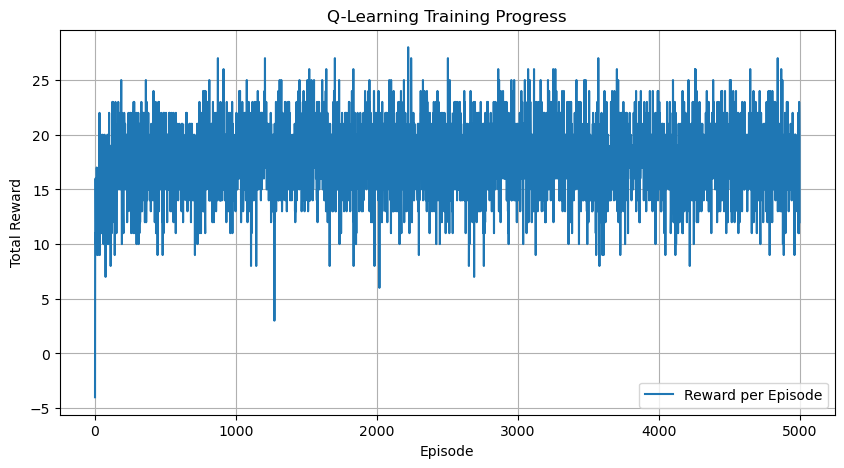

In [41]:
plt.figure(figsize=(10,5))
plt.plot(rewards_per_episode, label="Reward per Episode", color="tab:blue")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Q-Learning Training Progress")
plt.grid(True)
plt.legend()
plt.show()